# Contextualização do Problema e Solução Proposta
Costumo ler muitos posts do *medium.com* relacionado a ciência de dados, e a escolha de um bom post para ler acaba demandando muito tempo. Com isso, um **sistema de recomendação de posts do medium** com temas relacionados ao meu interesse, acabaria com a enorme quantidade de tempo perdido para escolher um bom post.

Há diversas estratégias para construção de sistemas de recomendação. Existem as baseadas em *filtragem por conteúdo*, *filtragem colaborativa*, porém a que utilizaremos aqui é simplesmente *prever e depois ordenar*.

De acordo com as **informações públicas** do medium, pensamos que o *título* é a principal feature para o modelo, e que algumas informações extras do posts também podem dar uma ajudinha para o modelo, como *quantidade de curtidas*, *comentários*, *tempo requerido para ler o post*, enfim, informações de engajamento em geral.

# Processo
É importante falar qual processo/método guiará esse trabalho. Após a concepção da ideia, debate de principais features a serem capturadas, haverá a exploração e limpeza dos dados, depois a escolha de uma boa métrica, criação de uma baseline, treinamento, otimização dos hiperparâmetros, validação e um pós-processamento nas previsões.

## Importação das bibliotecas

In [38]:
import pandas as pd 
import numpy as np
import re
import math
import string

#VISUALIZAÇÃO
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#NLTK
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize, WordPunctTokenizer

#WORDCLOUD
from wordcloud import WordCloud, STOPWORDS


## Carregando os dados
**Dicionário de dados:**
* **comments** : Comentários sobre o post
* **key_word** : Palavra chave que aparece no título do post
* **link** : Endereço público para o post
* **reading_time** : Tempo de leitura do post
* **title** : Título do post
* **target** : Variável alvo a ser predita (*1-Gostei e 0-Não gostei*)

In [2]:
df = pd.read_excel("dataset.xlsx")
df.head()

,Column1,comments,key_word,link,page,palms,reading_time,title,target
0,0,64 responses,Data%20Science,https://towardsdatascience.com/how-to-learn-da...,1,21K,9 min read,How To Learn Data Science If You’re Broke,1
1,1,77 responses,Data%20Science,https://towardsdatascience.com/how-to-build-a-...,1,17.8K,18 min read,How to Build a Data Science Portfolio,1
2,2,75 responses,Data%20Science,https://medium.com/civis-analytics/the-best-ma...,1,19.2K,6 min read,The best Mario Kart character according to dat...,1
3,3,51 responses,Data%20Science,https://medium.com/free-code-camp/if-you-want-...,1,7.2K,14 min read,"If you want to learn Data Science, start with ...",0
4,4,21 responses,Data%20Science,https://towardsdatascience.com/essential-math-...,1,13.4K,8 min read,Essential Math for Data Science,1


In [3]:
df.shape

(1485, 9)

## Limpeza dos dados
Nem todos os datasets vão estar bonitinhos como o conjunto de dados íris. Os dados de produção na maioria das vezes apresentam vários problemas para serem explorados e resolvidos. Portanto, a limpeza dos dados é essencial para que o modelo performe melhor, e também para que os algoritmos possam recebê-los sem dar nenhum erro.

Vamos remover algumas features que muito provavelmente não iriam contribuir para resolver o nosso problema.

In [4]:
df.drop(['Column1', 'link', 'page'], axis=1, inplace=True)

print(sum(df['comments'].isna()))
print(sum(df['reading_time'].isna()))
print(sum(df['palms'].isna()))

185
1
0


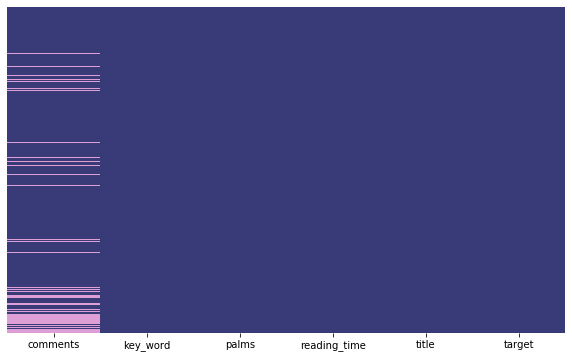

In [5]:
plt.figure(figsize=(10,6))
sns.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap='tab20b')#coolwarm

Temos 185 valores NaN na feature **comments**, porém com uma rápida investigação se percebe que a causa disso é que não temos nenhum comentário no post. Então vamos preencher os valores NaN com zeros.
Temos apenas 1 valor NaN na feature **reading_time**. **Inicialmente** vamos preencher com zero, pois essa feature ainda não está da maneira adequada para se fazer operações algébricas. Como não faz sentido preencher com zero, logo mais a frente, vamos preencher com um valor adequado. A feature **palms** não apresenta nenhum valor NaN.

In [6]:
df['comments'].fillna('0', inplace=True)
df['reading_time'].fillna('0', inplace=True)

É necessário retirar das features *comments, reading_time e palms* as palavras e deixar apenas dígitos numéricos para os algoritmos entenderem.

In [7]:
'''Remove todos os caracteres, deixando apenas os pontos finais e os dígitos'''
def parse_to_numeric(x):
    return re.sub('[^.0-9]', '', x)

In [8]:
'''Ajusta as strings para uma representação numérica adequada... Ex: 21K para 21000'''
def adjust_numbers(x):
    if re.sub('[.0-9]', '', x) == 'K':
        aux = float(re.sub('[^.0-9]', '', x))
        return aux * 1000
    else:
        return float(re.sub('[^.0-9]', '', x))

In [9]:
df['comments'] = df['comments'].apply(parse_to_numeric)
df['reading_time'] = df['reading_time'].apply(parse_to_numeric)
df['palms'] = df['palms'].apply(adjust_numbers)

In [10]:
df['comments'] = df['comments'].astype(int)
df['reading_time'] = df['reading_time'].astype(int)

Como dito anteriormente, vamos preencher adequadamente o *tempo de leitura*. Optei pela **mediana** já que possui pouca influência pelos *outliers*.

In [11]:
df.loc[df['reading_time'] == 0, ['reading_time']] = df.reading_time.median()

In [12]:
df['key_word'] = df['key_word'].str.replace('%20', ' ')
df['key_word'].value_counts()

Machine Learning    433
Deep Learning       410
Data Science        384
Kaggle              258
Name: key_word, dtype: int64

É necessário limpar a feature *title*, removendo as **stopwords**(palavras e caracteres irrelevantes), realizando algum processamento de strings que pelo domínio do negócio se acha necessário realizar, por exemplo, **decidi não remover a stopwords R**. Pois nesse contexto a palavra R é importante, pois se trata de uma linguagem de programação.

In [13]:
STOPWORDS.remove('r')
STOPWORDS.add('’')
STOPWORDS.add('“')
STOPWORDS.add('”')
STOPWORDS.add('—')

stopwords_ = STOPWORDS.union(set(string.punctuation)).union(set(stopwords.words('english')))

In [14]:
tokenizer = WordPunctTokenizer()

def remove_stopwords(title):
    new_title = list()
    title = title.lower()
    #title = unidecode.unidecode(title)
    words_title = tokenizer.tokenize(title)
    for w_title in words_title:
        if w_title not in stopwords_:
            new_title.append(w_title)
    return ' '.join(re.sub('[{}—]'.format(string.punctuation), ' ', ' '.join(new_title)).split())

df['title'] = df['title'].apply(remove_stopwords)

O nosso conjunto de dados possui 20 linhas duplicadas. Portanto, vamos **remover** as instâncias(linhas) **duplicadas**. Pois deixar linhas duplicadas pode enviesar o nosso modelo. 

In [15]:
print("Quantidade de linhas duplicadas:", len(df[df.duplicated(['comments', 'palms', 'reading_time', 'title'])]))
df.drop_duplicates(['comments', 'palms', 'reading_time', 'title'], keep='first', inplace=True)
print("Linhas x Colunas:", df.shape)

Quantidade de linhas duplicadas: 20
Linhas x Colunas: (1465, 6)


## Exploração dos dados
Essa etapa é tão importante quanto a limpeza, pois é nela que conhecemos as distribuições dos nossos dados, criamos hipóteses, concluímos algum pensamento, esclarecemos/respondemos algumas *indagações* iniciais, e podemos ter alguns **insights**.

Gosto do comando abaixo, porque nos dá uma informação de quanto o conjunto de dados consome em memória ao carregá-lo, e os tipos das features.

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1465 entries, 0 to 1484
Data columns (total 6 columns):
comments        1465 non-null int32
key_word        1465 non-null object
palms           1465 non-null float64
reading_time    1465 non-null float64
title           1465 non-null object
target          1465 non-null int64
dtypes: float64(2), int32(1), int64(1), object(2)
memory usage: 74.4+ KB


Ao verificar a quantidade de valores da feature alvo(target), percebemos um razoável desbalanceamento. E muitos dos problemas reais que enfrentamos são de caráter desbalanceado.

In [17]:
print(df['target'].value_counts())

1    902
0    563
Name: target, dtype: int64


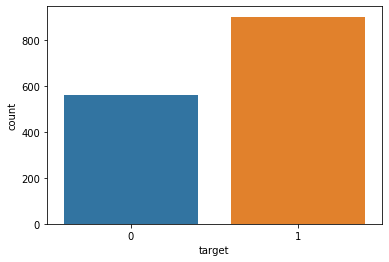

In [18]:
sns.countplot(x='target', data=df)

Abaixo vemos informações descritivas dos dados como a média, desvio padrão e mediana. Percebemos que a média do **tempo de leitura** é de 8 min e que a leitura máxima é de 1 hora. A média de **comentários** é de 9, mas não retrata bem a realidade dos dados, já que sua mediana é de apenas 4. Já as **curtidas** vemos um desvio padrão um pouco alto.

In [19]:
df.describe()

,comments,palms,reading_time,target
count,1465.000000,1465.000000,1465.000000,1465.000000
mean,9.046416,1741.686689,8.375427,0.615700
std,16.487635,3878.784063,5.318382,0.486596
min,0.000000,3.000000,1.000000,0.000000
25%,2.000000,432.000000,5.000000,0.000000
50%,4.000000,787.000000,7.000000,1.000000
75%,10.000000,1500.000000,10.000000,1.000000
max,275.000000,86000.000000,60.000000,1.000000


O método distplot nos fornece um **gráfico de distribuição**, com uma **estimativa da densidade dos dados(KDE)**, calculando a probabilidade de se ter um ponto naquele local do gráfico. O que podemos enchergar é que as três features abaixo não segue uma *distribuição normal*, pois a maioria dos dados estão concentrados no inicio do gráfico, tendo assim um certo **enviesamento** para um dos lados. Não é uma surpresa, já que não são todos os posts que possuem muitas curtidas, comentários e posts longos.

[Text(0, 0.5, '% Distribuição'),
 Text(0.5, 0, 'Quantidade de Comentários'),
 Text(0.5, 1.0, 'Gráfico de Densidade de Comentários')]

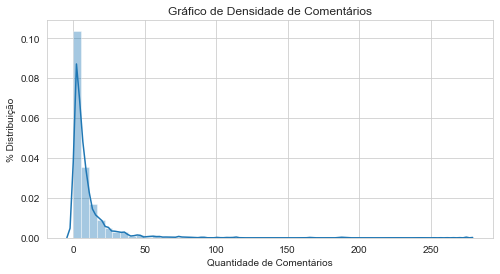

In [20]:
plt.figure(figsize=(8,4))
sns.set_style("whitegrid")
ax=sns.distplot(df.comments)
ax.set(xlabel='Quantidade de Comentários', 
       ylabel='% Distribuição',title='Gráfico de Densidade de Comentários')

[Text(0, 0.5, '% Distribuição'),
 Text(0.5, 0, 'Quantidade de Curtidas'),
 Text(0.5, 1.0, 'Gráfico de Densidade de Curtidas')]

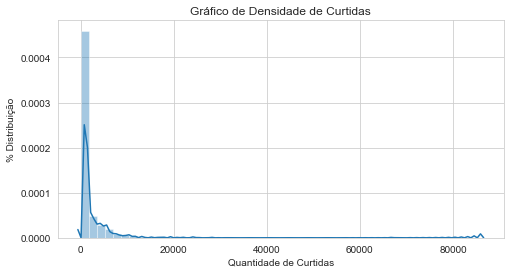

In [21]:
plt.figure(figsize=(8,4))
ax=sns.distplot(df.palms)
ax.set(xlabel='Quantidade de Curtidas', 
       ylabel='% Distribuição',title='Gráfico de Densidade de Curtidas')

[Text(0, 0.5, '% Distribuição'),
 Text(0.5, 0, 'Tempo de Leitura'),
 Text(0.5, 1.0, 'Gráfico de Densidade do Tempo de Leitura')]

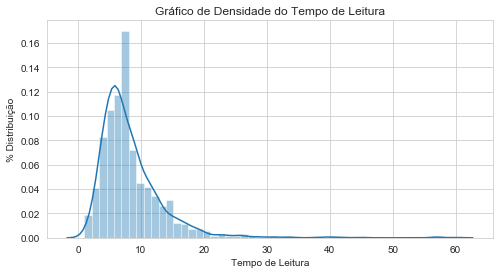

In [22]:
plt.figure(figsize=(8,4))
ax=sns.distplot(df.reading_time)
ax.set(xlabel='Tempo de Leitura', 
       ylabel='% Distribuição',title='Gráfico de Densidade do Tempo de Leitura')

Os **boxplots** nos permitem a visualizar outliers, mediana, máximos, mínimos e os quartis. Nas features reading_time, palms e comments temos vários *outliers*, mas existem alguns que se descatacam ainda mais. Nos *comments* e *palms* quase não conseguimos visualizar bem a mediana, pois os dados estão bem próximos do zero.

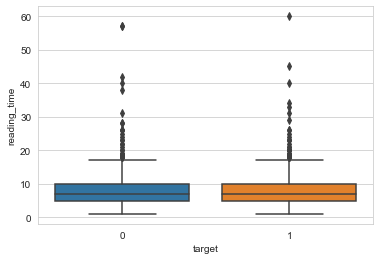

In [23]:
sns.boxplot(x='target', y='reading_time', data=df)

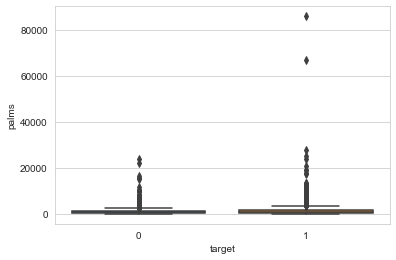

In [24]:
sns.boxplot(x='target', y='palms', data=df)

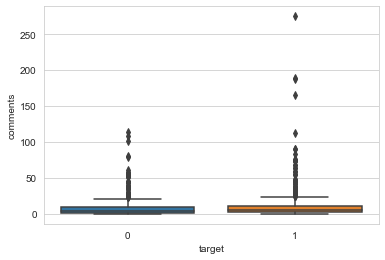

In [25]:
sns.boxplot(x='target', y='comments', data=df)

Outros tipos de gráficos que mostram a **distribuição dos dados** são os *stripplots* e *swarmplots*, onde o swarmplot mostra os dados não sobrepostos. Nos *comments* os outliers acima de 150 se destacam, no *reading_time* os acima de 30 minutos e já os *palms* acima de 60K.

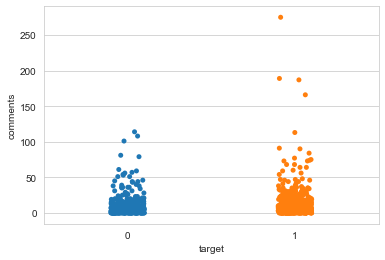

In [26]:
sns.stripplot(x='target', y='comments', data=df)

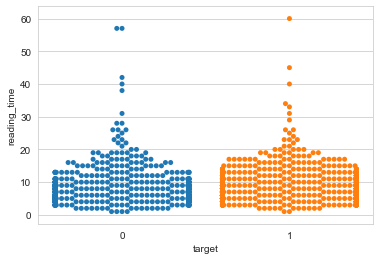

In [27]:
sns.swarmplot(x='target', y='reading_time', data=df)

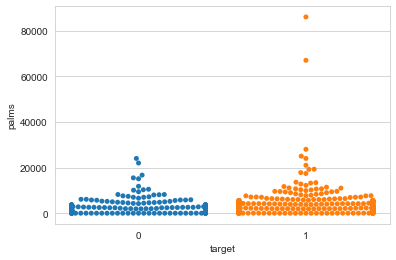

In [28]:
sns.swarmplot(x='target', y='palms', data=df)

Abaixo visualizamos as relações entre variáveis. Percebemos que *comments* e *palms* tem uma certa **relação linear positiva**. Essa relação é esperada, já que posts com mais *curtidas* tendem a ter também vários *comentários*. Obviamente, não significa que uma causa a outra. As outras combinações de relações não tem nenhuma *relação aparente*. 

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


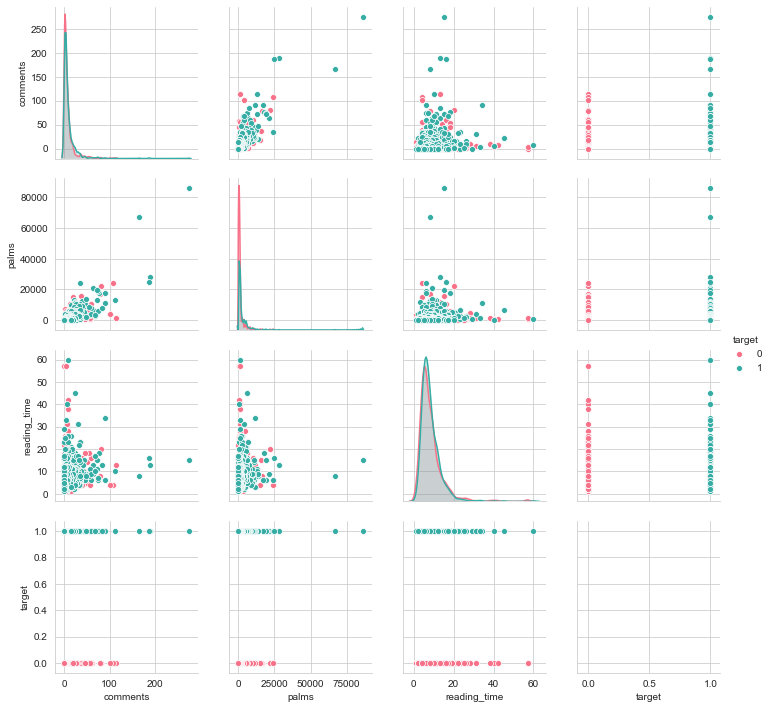

In [29]:
sns.pairplot(df, hue="target", palette="husl")

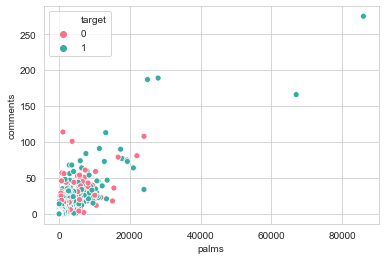

In [30]:
sns.scatterplot(x=df.palms, y=df.comments, hue=df.target, palette="husl")

As features *palms* e *comments* possuem uma **distribuição inclinação à direita**, isso quer dizer que a possuem uma longa cauda na direção positiva no eixo x. Vamos aplicar o log(1+x) nos dados para aproximar a uma distribuição normal.

In [31]:
df['log_comments'] = np.log10(1+df['comments'])
df['log_palms'] = np.log10(1+df['palms'])
df['log_reading_time'] = np.log10(1+df['reading_time'])

Text(0.5, 0.98, 'Gráfico de Pares dos Dados de Posts Medium')

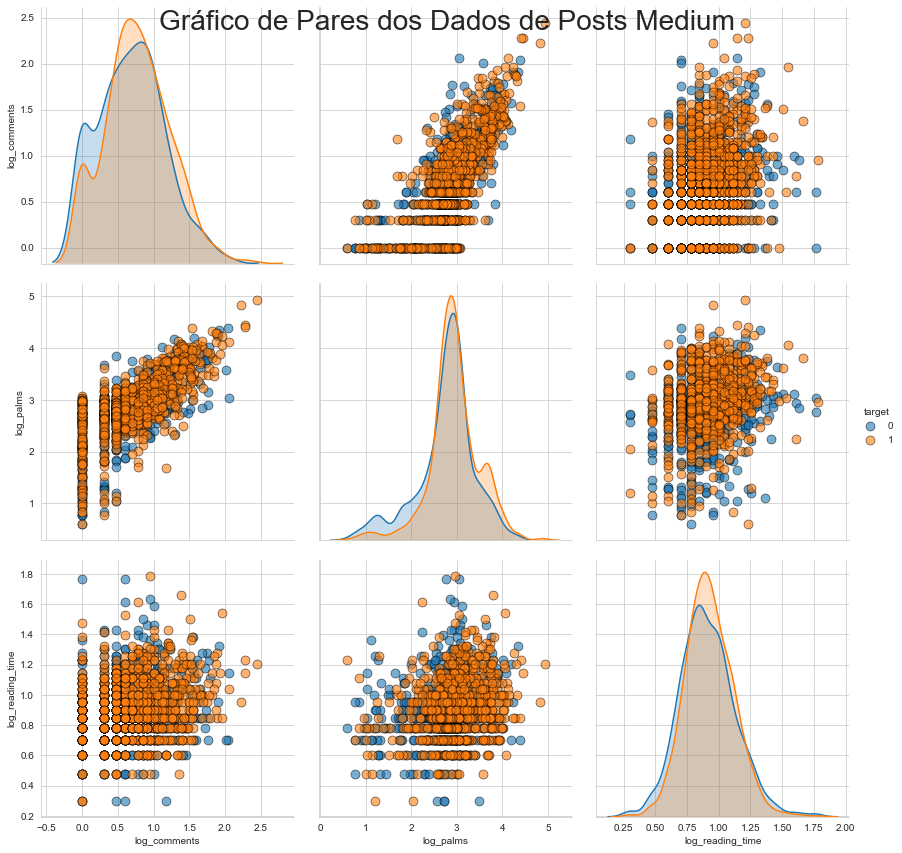

In [32]:
sns.pairplot(df, 
             vars = ['log_comments', 'log_palms', 'log_reading_time'],
             hue = 'target', diag_kind = 'kde', 
             plot_kws = {'alpha': 0.6, 's': 80, 'edgecolor': 'k'},
             height=4)
plt.suptitle('Gráfico de Pares dos Dados de Posts Medium', size = 28)

Com a ajuda do PairGrid, podemos plotar junto histograma (diagonal), disperção (superior) e kde bivariável (inferior).

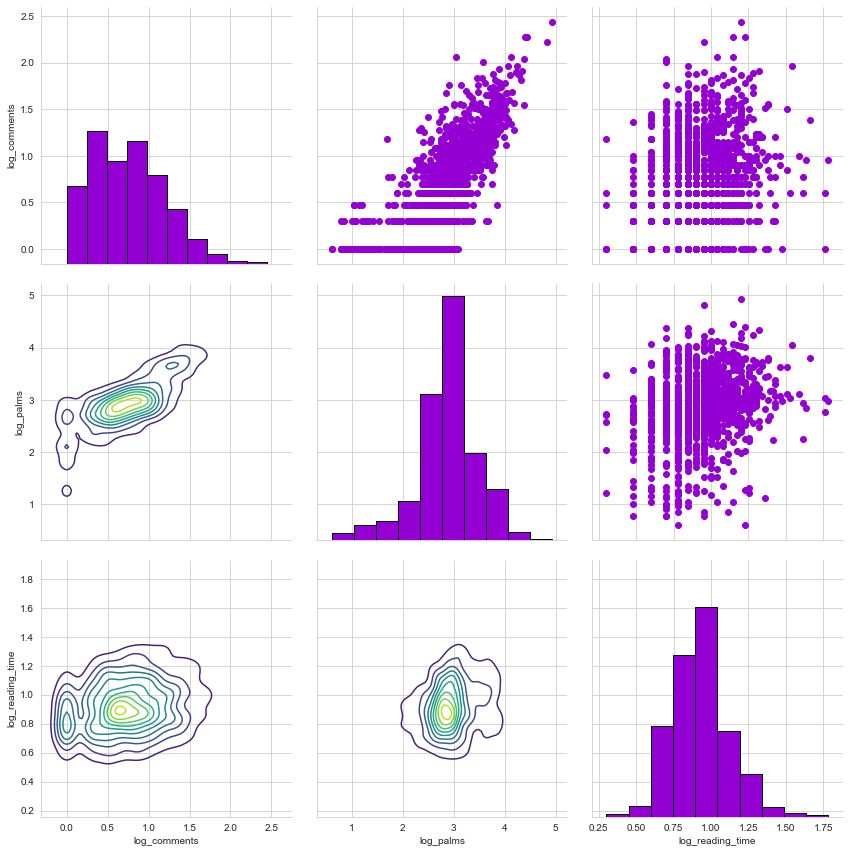

In [33]:
grid = sns.PairGrid(data=df, vars = ['log_comments', 'log_palms', 'log_reading_time'], height=4)

grid = grid.map_upper(plt.scatter, color = 'darkviolet')
grid = grid.map_diag(plt.hist, bins = 10, color = 'darkviolet',edgecolor = 'k')
grid = grid.map_lower(sns.kdeplot, cmap = 'viridis')

A **correlação** nos ajuda a enxergar o quanto uma feature está relacionada a outra. Existem várias maneiras de se calcular, como: a de *Pearson, Spearman*, *Tau de Kendall* etc. Lembre-se, correlação não é sinônimo de causa. Neste problema, optei por usar a correlação de Pearson, pois é uma medida de relação linear entre variáveis contínuas. Percebemos que a feature *palms* tem uma certa relação forte com *comments*.

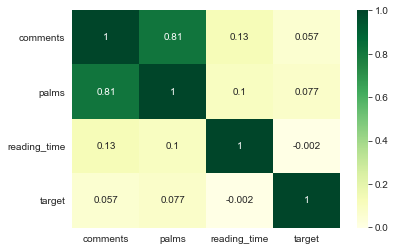

In [34]:
corr = df[['comments', 'palms', 'reading_time', 'target']].corr(method='pearson')
sns.heatmap(corr, annot=True, cmap='YlGn')

Por fim, vamos plotar uma nuvem de palavras (**Word Cloud**), para entendermos um pouco mais sobre a que julgamos inicialmente, a feature mais importante do modelo (title). 

Optei por remover as stopwords e *6 palavras chaves*, já que todas elas tem no título, e certamente estariam em destaque. Vemos que a palavra **part**, **python** e **using** ficam em evidência. Isso quer dizer que existem vários posts divididos em partes e que geralmente os posts usam python, obviamente nessa amostra de dados.

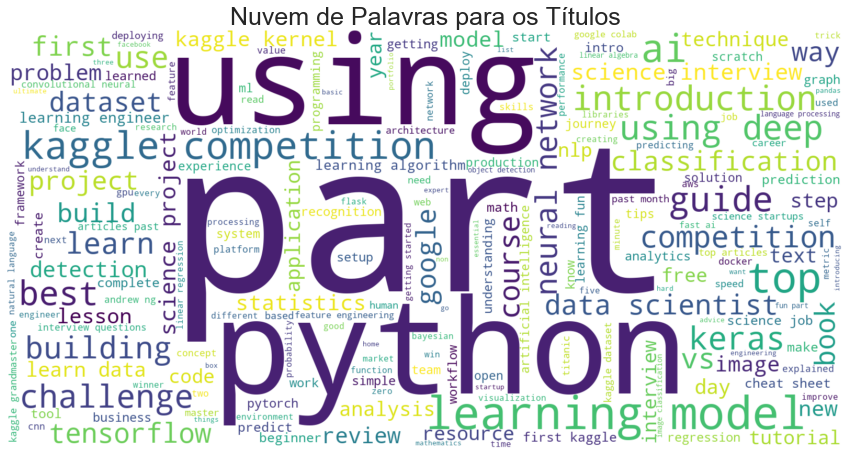

In [35]:
sw = stopwords_.union({'deep', 'learning', 'machine', 'kaggle', 'data', 'science'})

all_title = " ".join(s for s in df['title'].str.lower())
wordcloud = WordCloud(stopwords=sw,
                      background_color="white",
                      #max_words = 100,
                      width=1600, height=800,
                      random_state = 42).generate(all_title)
plt.figure(figsize = (15,15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Nuvem de Palavras para os Títulos", fontsize = 25)
plt.axis("off")
plt.show()

<h2> Salvando os dados limpos </h2>

In [36]:
df.to_csv("dataset_clean.csv")

In [37]:
df.head()

,comments,key_word,palms,reading_time,title,target,log_comments,log_palms,log_reading_time
0,64,Data Science,21000.0,9.0,learn data science broke,1,1.812913,4.322240,1.000000
1,77,Data Science,17800.0,18.0,build data science portfolio,1,1.892095,4.250444,1.278754
2,75,Data Science,19200.0,6.0,best mario kart character according data science,1,1.880814,4.283324,0.845098
3,51,Data Science,7200.0,14.0,want learn data science start one programming ...,0,1.716003,3.857393,1.176091
4,21,Data Science,13400.0,8.0,essential math data science,1,1.342423,4.127137,0.954243
